In [43]:
from catboost import CatBoostClassifier
import rasterio
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import os

from api import call_api
from Nesterov_koef import CFD

In [44]:
resizing = [135, 106]

In [45]:
def transform(img_path):
    with rasterio.open(img_path) as src:
        red = src.read(1)  # B02 - Blue
        green = src.read(2)  # B03 - Green
        blue = src.read(3)  # B04 - Red
        ik = src.read(4)
        target = src.read(5)

        cords = get_coords(img_path)
        json = call_api(cords[0], cords[1], get_time(img_path)) 
        data = pd.DataFrame(json)
        data = data[['max_temp', 'dewpt', 'precip']].to_numpy() #'precip', 'dewpt', 'max_temp'
        coefs = CFD(data[:, 0], data[:, 1], data[:, 2])
        vector_expanded = np.tile(coefs, (135*106, 1))

        img = np.stack([red, green, blue, ik, target], axis=-1)

        img = cv2.resize(img, (135, 106))
        
        img[:, :, 4][img[:, :, 4] < 0.5] = 0
        img[:, :, 4][img[:, :, 4] >= 0.5] = 1
        
        img = img.reshape([135 * 106, 5])
        result = np.hstack((img, vector_expanded))

        return result
    
def get_coords(img_path):
    with rasterio.open(img_path) as src:
            return [src.bounds.top, src.bounds.left]
    
def get_time(img_path):
     return img_path[4:-5]

In [46]:
PATHS = ["00//2021-06-06.tiff",
         "01//2021-05-26.tiff",
         "02//2021-06-03.tiff",
         "03//2021-06-03.tiff",
         "04//2021-06-06.tiff",
         "05//2021-06-03.tiff",
         "06//2021-06-03.tiff",
         "07//2021-06-03.tiff",
         "08//2021-06-08.tiff",
         "09//2021-06-16.tiff",
         "10//2021-06-16.tiff",
         "11//2018-06-01.tiff",
         "12//2019-05-10.tiff",
         "13//2019-05-17.tiff",
         "14//2019-05-28.tiff",
         "15//2020-05-02.tiff",
         "16//2020-05-09.tiff",
         "17//2020-05-31.tiff",
         "18//2021-05-02.tiff",
         "19//2021-05-04.tiff",
         "20//2021-05-15.tiff"]

In [48]:
img = []
for i, e in enumerate(PATHS):
    img.append(transform(e))
    
img = np.array(img)
img = img.reshape([21*14310, 35])

In [49]:
to_train = np.delete(img, 4, axis=1)
to_test = img[:, 4]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(to_train, to_test, test_size=0.2, random_state=42)

In [51]:
model = CatBoostClassifier(iterations=15000, learning_rate=0.05, depth=6, loss_function='MultiLogloss')
model.fit(X_train, y_train, verbose=100, eval_set=(X_test, y_test))

0:	learn: 0.6241571	test: 0.6241802	best: 0.6241802 (0)	total: 109ms	remaining: 27m 9s
100:	learn: 0.1919500	test: 0.1908457	best: 0.1908457 (100)	total: 6.23s	remaining: 15m 19s
200:	learn: 0.1857128	test: 0.1851757	best: 0.1851757 (200)	total: 12.3s	remaining: 15m 9s
300:	learn: 0.1825095	test: 0.1826395	best: 0.1826395 (300)	total: 18.5s	remaining: 15m 1s
400:	learn: 0.1800510	test: 0.1810185	best: 0.1810185 (400)	total: 24.6s	remaining: 14m 57s
500:	learn: 0.1780340	test: 0.1797096	best: 0.1797096 (500)	total: 30.8s	remaining: 14m 52s
600:	learn: 0.1761771	test: 0.1786370	best: 0.1786370 (600)	total: 37s	remaining: 14m 46s
700:	learn: 0.1747170	test: 0.1778570	best: 0.1778570 (700)	total: 43.2s	remaining: 14m 40s
800:	learn: 0.1733846	test: 0.1771906	best: 0.1771906 (800)	total: 49.4s	remaining: 14m 36s
900:	learn: 0.1722513	test: 0.1767001	best: 0.1766995 (899)	total: 55.8s	remaining: 14m 33s
1000:	learn: 0.1712280	test: 0.1762989	best: 0.1762975 (999)	total: 1m 2s	remaining: 14m 

In [53]:
final = transform("19//2021-05-04.tiff")
mask = model.predict(final)
mask = mask.reshape([106,135,1])

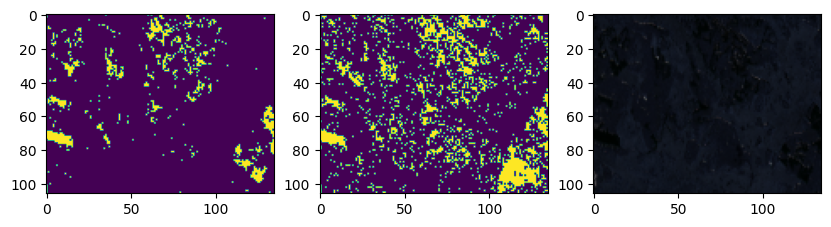

In [235]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
to_draw = final.reshape([106,135,5])
axs[0].imshow(mask)
axs[1].imshow(to_draw[:,:,4])
axs[2].imshow(to_draw[:,:,:3]/255)

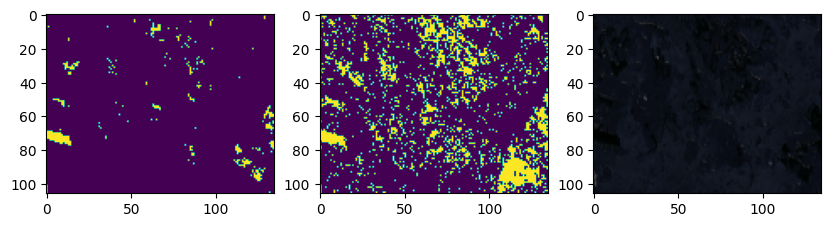

In [41]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
to_draw = final.reshape([106,135,65])
axs[0].imshow(mask)
axs[1].imshow(to_draw[:,:,4])
axs[2].imshow(to_draw[:,:,:3]/255)

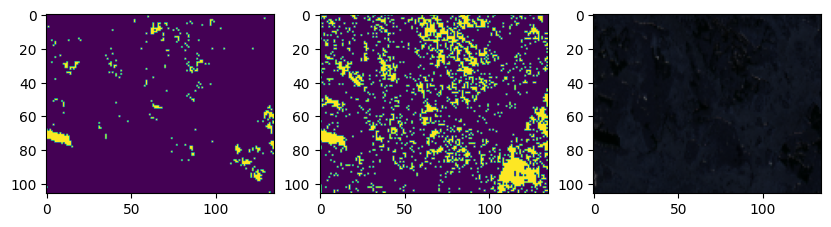

In [55]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
to_draw = final.reshape([106,135,35])
axs[0].imshow(mask)
axs[1].imshow(to_draw[:,:,4])
axs[2].imshow(to_draw[:,:,:3]/255)